# Average age at infection in the SIR model
Continuing our investigation of the Susceptible-Infected-Recovered model, we will add demographics and investigate the behavior of the model in and around the endemic equilibrium.  The first 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

Analysis of this system can be found in other sources (ref. Keeling/Rohani).  Setting the derivatives to zero and doing a bit of algebra gets you to the endemic equilbrium

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

An individual susceptible's mean time to infection will then be the inverse of the total force of infection, $\beta I^*$.  
$$
\tau_{S \rightarrow I} = \frac{1}{\mu (R_0 -1)}
$$

The equation above is often also described as the average age at infection.  However, it is key to remember that the measured age at infection will be censored by non-disease deaths occurring at a rate $\mu$.  You can work through the impact of this, but in the simple case of constant mortality, it turns out to exactly balance out the $-1$ in the above equation, and so our *observed* average age at infection will be $\frac{1}{\mu R_0}$.  Since the hazard is constant at equilibrium, this implies an exponential distribution:

$$P(a | S->I) \sim \mu R_0 e^{-\mu R_0 a}$$

Alternatively, we can correct for the influence of mortality by observing the fraction of children who are susceptible at age A, which necessarily conditions on survival to age A.  This will look like the cumulative distribution of an exponential distributed according to the mean time to infection above:

$$P(R | a) \sim 1 - e^{(-a \mu (R_0-1))}$$

### Contruct the model
In the first few cells, we do all the necessary imports.  Because we are now measuring an equilibrium property of this system, we will have to burn in, with repeated infection importations to ensure that we establish an endemic equilibrium.  We also need to model a large enough population to sustain the infection (see Critical Community Size notebook).  The primary determinant of the critical community size is the duration of infection, so keeping this relatively long (2 months) prevents us from needing huge agent populations.  So, we construct a single-patch LASER model with fice components: `Births_ConstantPop`, `Susceptibility`, `Transmission`, `Infection`, and `Infect_Random_Agents`, a function that implements repeated importation for a fixed period of time. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will sample a set of $(\mu, R_0)$ pairs and confirm that both the age at infection and the fraction of susceptibles at a given age are well-described by exponential distributions and that the associated rate constant is as expected.   

### Future work
The addition of an exposed compartment should not change this result (other than changing the relevant transition from S->E rather than S->I) and we should test this.  



In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import fsolve
import scipy.fftpack as fftpack

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents
from scipy.stats import expon
from scipy.stats import kstest
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error


from laser_generic.utils import set_initial_susceptibility_randomly
from laser_generic.utils import seed_infections_randomly

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [2]:
scenario = pd.DataFrame(data=[["homenode", 1e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet(
    {"seed": 4, "nticks": 18250, "verbose": True, "beta": 0.1, "inf_mean": 60, "cbr": 90, "importation_period": 180, "importation_count": 3}
)

2025-03-05 11:51:52.629315: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:51:52.634797: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:05<00:00, 3187.87it/s]

Completed the generic model at 2025-03-05 11:51:58.385907…
Susceptibility_census:       366,264 µs
Infection_census     :       883,462 µs
Transmission_census  :       442,880 µs
Model                :        48,838 µs
Infect_Random_Agents :        43,316 µs
Births_ConstantPop   :     2,604,078 µs
Susceptibility       :        20,672 µs
Infection            :     1,264,266 µs
Transmission         :     5,442,254 µs
Total:                    11,116,030 microseconds


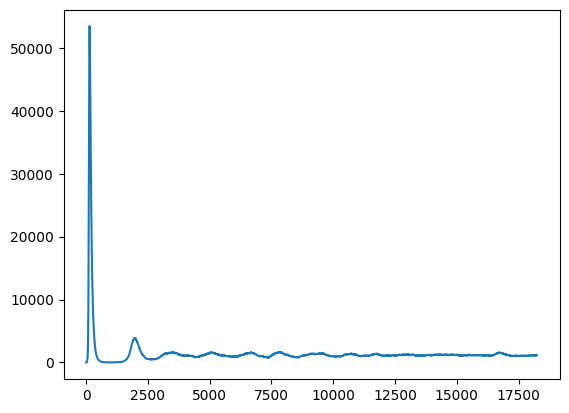

In [3]:
model = Model(scenario, parameters)
model.components = [
    Infect_Random_Agents,
    Births_ConstantPop,
    Susceptibility,
    Infection,
    Transmission,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times.

In [4]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
births = np.squeeze(model.patches.births)
pops = np.squeeze(model.patches.populations)[:-1]

print("S+I+R = N:  " + str(np.isclose(cases + susc + rec, pops).all()))

S+I+R = N:  True


### First scientific test check
As usual, we will test this on a single simulation instance and demonstrate the analysis, before moving on to testing over a range of input values.  
Here, we are interested in equilibrium behavior, so I first place a cut to exclude all infections that occur before day 10000. We then plot the data, an exponential distribution with the expected value of $\frac{1}{R_0 \mu}$, a best-fit exponential distribution to the data, and perform a KS test. 

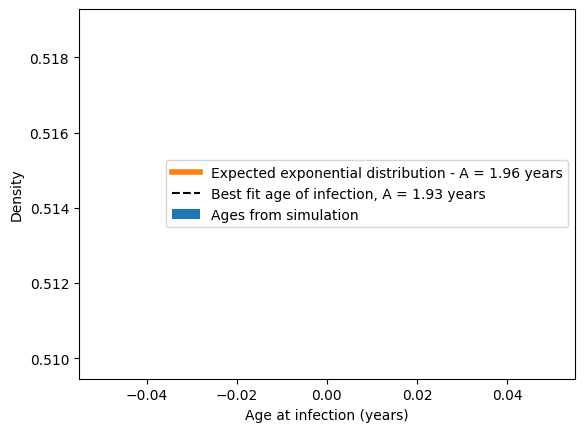

KstestResult(statistic=0.0026297177221289436, pvalue=0.7119393450505571, statistic_location=0.5698630136986301, statistic_sign=1)

In [5]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / ((R0) * mu) / 365
a = np.arange(0, 15, 100)


def fit_age_at_infection(model):
    cut = model.population.doi > 10000
    data = (model.population.doi[cut] - model.population.dob[cut]) / 365
    expfit = expon.fit(data)
    fitqual = kstest(data, expon.cdf, expfit)
    return data, expfit, fitqual


data, expfit, fitqual = fit_age_at_infection(model)


plt.hist(data, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Age at infection (years)")
plt.ylabel("Density")
plt.legend(
    [
        f"Expected exponential distribution - A = {A:.2f} years",
        f"Best fit age of infection, A = {expfit[1]:.2f} years",
        "Ages from simulation",
    ]
)
plt.show()
fitqual

### Second scientific test check
As noted above, because of the censoring that mortality induces, the distributions of age at infection vs. fraction susceptible at a given age will both follow exponential behavior but with a slight difference in the mean of the distribution - for the fraction susceptible, that value will be $\frac{1}{\mu (R_0-1)}$.  We develop this second test below. 

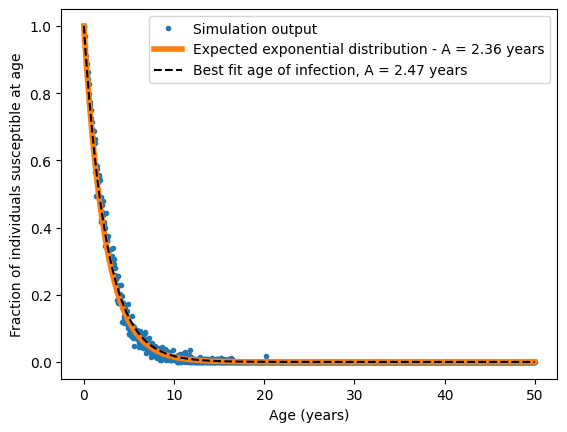

RMSE =  0.010549283479683653


In [6]:
A2 = 1 / ((R0 - 1) * mu) / 365


def Scurve(x, lam):
    return np.exp(-x / lam)


def fit_susceptibility_vs_age(model):
    cut = (model.population.susceptibility == 1) & (model.population.dob > 10000)
    bins = np.linspace(0, 50, 1200)
    age_years = (np.max(model.population.dob) - model.population.dob) / 365
    n1 = np.histogram(age_years, bins=bins)[0]
    n2 = np.histogram(age_years[cut], bins=bins)[0]
    n1[n1 == 0] = 1
    y1 = n2 / n1
    popt, pcov = curve_fit(Scurve, bins[:-1] + np.mean(np.diff(bins)), y1, p0=2.5)
    mse = mean_squared_error(y1, Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, *popt))
    return y1, bins, popt, pcov, mse


data, bins, popt, pcov, mse = fit_susceptibility_vs_age(model)

# Plotting is a little more complicated here, want to plot at the bin centers and force y=1 at x=0
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *data], ".")
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *(Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, A2))], lw=4)
plt.plot([0, *bins[:-1] + np.mean(np.diff(bins)) / 2], [1, *(Scurve(bins[:-1] + np.mean(np.diff(bins)) / 2, *popt))], "k--")
plt.legend(
    ["Simulation output", f"Expected exponential distribution - A = {A2:.2f} years", f"Best fit age of infection, A = {popt[0]:.2f} years"]
)
plt.xlabel("Age (years)")
plt.ylabel("Fraction of individuals susceptible at age")
plt.show()
print("RMSE = ", np.sqrt(mse))

### Third scientific test
As long as we are here, let's test that the age distribution of the population is correct.  With constant birth rate, equal to death rate, the population should have exponentially distributed ages with parameter $\frac{1}{\mu}$

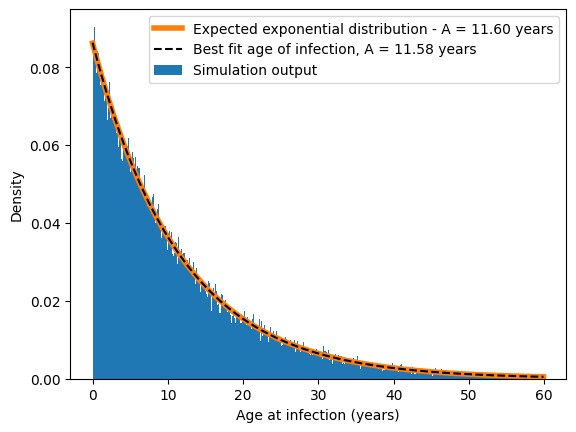

KstestResult(statistic=0.0030743868112242945, pvalue=0.3003816575133943, statistic_location=4.545205479452055, statistic_sign=-1)

In [ ]:
# Test that population age distribution is correct
def fit_population_age_distribution(model):
    age_years = (np.max(model.population.dob) - model.population.dob) / 365
    expfit = expon.fit(age_years)
    fitqual = kstest(age_years, expon.cdf, expfit)
    return age_years, expfit, fitqual


age_years, expfit, fitqual = fit_population_age_distribution(model)
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
A = 1 / mu / 365
a = np.arange(0, 60, 0.1)

plt.hist(age_years, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Age at infection (years)")
plt.ylabel("Density")
plt.legend(
    [f"Expected exponential distribution - A = {A:.2f} years", f"Best fit age of infection, A = {expfit[1]:.2f} years", "Simulation output"]
)
plt.show()
fitqual


### Testing for many values
OK, so now we are going to replicate the above for many values of R0 and cbr, as a scientific validity test.

In [82]:
# OK, testing this is a bit more of a pain, since we are running out to some equilibrium-ish condition.
# With a large initial outbreak from full susceptibility, this could be a long time to equilibrate.
# Partial solution - start us near R-eff=1, but not with the age distribution that we expect, and
# let it equilibrate towards that age distribution over a couple of generations.  Still not ideal but
# probably faster than starting from S=1.

scenario = pd.DataFrame(data=[["homenode", 3e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])

cbrs = 15 + 85 * np.random.rand(100)
inf_means = 5 + 45 * np.random.rand(100)
R0s = 1.5 + 8.5 * np.random.rand(100)
output = pd.DataFrame(data={"cbr": cbrs, "inf_mean": inf_means, "R0": R0s})
output["Average_Iage_observed"] = np.nan
output["Average_Iage_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Idata_KStest"] = np.nan
for index, row in output.iterrows():
    mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 18250,
            "verbose": True,
            "beta": row["R0"] * (mu + 1 / row["inf_mean"]),
            "inf_mean": row["inf_mean"],
            "cbr": row["cbr"],
            "importation_period": 180,
            "importation_count": 3,
        }
    )

    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]
    set_initial_susceptibility_randomly(model, 1 / row["R0"] + 0.05)
    seed_infections_randomly(model, ninfections=1)
    model.run()

    cut = model.population.doi > 10000
    age_inf = model.population.doi[cut] - model.population.dob[cut]
    params = expon.fit(age_inf)
    output.loc[index, "Average_Iage_expected"] = 1 / (row["R0"] * mu) / 365
    output.loc[index, "Average_Iage_observed"] = params[1] / 365
    output.loc[index, "Idata_KStest_obs"] = kstest(age_inf, expon.cdf(params))[0]
    output.loc[index, "Idata_KStest_exp"] = kstest(age_inf, expon.cdf(output.loc[index, "Average_Iage_expected"]))[0]

    age_total = parameters.nticks - model.population.dob
    params = expon.fit(age_total)
    output.loc[index, "Average_age_expected"] = 1000 / model.params.cbr
    output.loc[index, "Average_age_observed"] = params[1] / 365
    output.loc[index, "Adata_KStest_obs"] = kstest(age_total, expon.cdf(params))[0]
    output.loc[index, "Adata_KStest_exp"] = kstest(age_total, expon.cdf(output.loc[index, "Average_age_expected"]))[0]


output.to_csv("SIR_output.csv")

2025-03-05 11:36:02.661990: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:36:02.669820: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1602.46it/s]


Completed the generic model at 2025-03-05 11:36:14.060124…
Susceptibility_census:       774,684 µs
Transmission_census  :     1,088,672 µs
Infection_census     :     2,105,128 µs
Model                :        56,364 µs
Births_ConstantPop   :     4,088,518 µs
Susceptibility       :        24,284 µs
Transmission         :    11,456,052 µs
Infection            :     2,650,698 µs
Infect_Random_Agents :        71,584 µs
Total:                    22,315,984 microseconds
2025-03-05 11:36:14.301882: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:36:14.308244: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1632.24it/s]


Completed the generic model at 2025-03-05 11:36:25.490454…
Susceptibility_census:       778,640 µs
Transmission_census  :     1,093,084 µs
Infection_census     :     2,282,570 µs
Model                :        57,098 µs
Births_ConstantPop   :     3,806,180 µs
Susceptibility       :        24,488 µs
Transmission         :    11,180,378 µs
Infection            :     2,603,264 µs
Infect_Random_Agents :        71,182 µs
Total:                    21,896,884 microseconds
2025-03-05 11:36:25.699583: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:36:25.706255: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1346.37it/s]


Completed the generic model at 2025-03-05 11:36:39.262750…
Susceptibility_census:       786,610 µs
Transmission_census  :     1,101,424 µs
Infection_census     :     2,425,652 µs
Model                :        57,672 µs
Births_ConstantPop   :     4,449,870 µs
Susceptibility       :        24,026 µs
Transmission         :    14,596,602 µs
Infection            :     3,125,034 µs
Infect_Random_Agents :        66,484 µs
Total:                    26,633,374 microseconds
2025-03-05 11:36:39.501134: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:36:39.506813: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1325.63it/s]


Completed the generic model at 2025-03-05 11:36:53.275187…
Susceptibility_census:       760,790 µs
Transmission_census  :     1,088,408 µs
Infection_census     :     2,073,978 µs
Model                :        54,920 µs
Births_ConstantPop   :     4,325,138 µs
Susceptibility       :        23,326 µs
Transmission         :    15,829,898 µs
Infection            :     2,849,768 µs
Infect_Random_Agents :        62,352 µs
Total:                    27,068,578 microseconds
2025-03-05 11:36:53.492561: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:36:53.498783: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1537.32it/s]


Completed the generic model at 2025-03-05 11:37:05.371271…
Susceptibility_census:       733,874 µs
Transmission_census  :     1,056,934 µs
Infection_census     :     2,086,204 µs
Model                :        54,230 µs
Births_ConstantPop   :     4,151,050 µs
Susceptibility       :        23,390 µs
Transmission         :    12,571,008 µs
Infection            :     2,561,694 µs
Infect_Random_Agents :        63,712 µs
Total:                    23,302,096 microseconds
2025-03-05 11:37:05.580482: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:37:05.586531: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1437.49it/s]


Completed the generic model at 2025-03-05 11:37:18.283605…
Susceptibility_census:       779,678 µs
Transmission_census  :     1,114,018 µs
Infection_census     :     1,990,362 µs
Model                :        55,186 µs
Births_ConstantPop   :     4,258,288 µs
Susceptibility       :        24,384 µs
Transmission         :    13,637,730 µs
Infection            :     2,993,460 µs
Infect_Random_Agents :        68,746 µs
Total:                    24,921,852 microseconds
2025-03-05 11:37:18.522417: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:37:18.527739: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:17<00:00, 1020.84it/s]


Completed the generic model at 2025-03-05 11:37:36.406569…
Susceptibility_census:       830,494 µs
Transmission_census  :     1,161,888 µs
Infection_census     :     2,428,594 µs
Model                :        61,662 µs
Births_ConstantPop   :     4,817,260 µs
Susceptibility       :        25,410 µs
Transmission         :    22,707,088 µs
Infection            :     3,115,486 µs
Infect_Random_Agents :        64,180 µs
Total:                    35,212,062 microseconds
2025-03-05 11:37:36.609134: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:37:36.614826: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1314.47it/s]


Completed the generic model at 2025-03-05 11:37:50.499996…
Susceptibility_census:       790,988 µs
Transmission_census  :     1,090,846 µs
Infection_census     :     2,492,584 µs
Model                :        60,130 µs
Births_ConstantPop   :     4,499,842 µs
Susceptibility       :        24,880 µs
Transmission         :    15,523,394 µs
Infection            :     2,724,460 µs
Infect_Random_Agents :        66,244 µs
Total:                    27,273,368 microseconds
2025-03-05 11:37:50.687365: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:37:50.694184: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1498.05it/s]


Completed the generic model at 2025-03-05 11:38:02.878965…
Susceptibility_census:       756,962 µs
Transmission_census  :     1,076,724 µs
Infection_census     :     2,481,320 µs
Model                :        56,204 µs
Births_ConstantPop   :     4,200,974 µs
Susceptibility       :        23,938 µs
Transmission         :    12,570,836 µs
Infection            :     2,677,884 µs
Infect_Random_Agents :        64,472 µs
Total:                    23,909,314 microseconds
2025-03-05 11:38:03.109286: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:38:03.115014: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:19<00:00, 942.58it/s] 


Completed the generic model at 2025-03-05 11:38:22.478107…
Susceptibility_census:       858,094 µs
Transmission_census  :     1,168,838 µs
Infection_census     :     2,552,126 µs
Model                :        60,970 µs
Births_ConstantPop   :     5,350,408 µs
Susceptibility       :        25,258 µs
Transmission         :    24,441,582 µs
Infection            :     3,627,330 µs
Infect_Random_Agents :        68,752 µs
Total:                    38,153,358 microseconds
2025-03-05 11:38:22.689474: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:38:22.705394: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:17<00:00, 1029.96it/s]


Completed the generic model at 2025-03-05 11:38:40.425785…
Susceptibility_census:       810,720 µs
Transmission_census  :     1,122,654 µs
Infection_census     :     2,345,088 µs
Model                :        58,958 µs
Births_ConstantPop   :     4,656,326 µs
Susceptibility       :        24,600 µs
Transmission         :    22,681,496 µs
Infection            :     3,145,600 µs
Infect_Random_Agents :        64,826 µs
Total:                    34,910,268 microseconds
2025-03-05 11:38:40.603544: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:38:40.609059: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1463.45it/s]


Completed the generic model at 2025-03-05 11:38:53.080933…
Susceptibility_census:       739,168 µs
Transmission_census  :     1,047,452 µs
Infection_census     :     2,591,008 µs
Model                :        55,006 µs
Births_ConstantPop   :     3,775,266 µs
Susceptibility       :        24,002 µs
Transmission         :    13,745,798 µs
Infection            :     2,444,078 µs
Infect_Random_Agents :        62,196 µs
Total:                    24,483,974 microseconds
2025-03-05 11:38:53.313644: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:38:53.320027: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1263.85it/s]


Completed the generic model at 2025-03-05 11:39:07.761854…
Susceptibility_census:       747,498 µs
Transmission_census  :     1,041,872 µs
Infection_census     :     2,925,782 µs
Model                :        58,572 µs
Births_ConstantPop   :     3,994,516 µs
Susceptibility       :        24,338 µs
Transmission         :    17,238,978 µs
Infection            :     2,301,428 µs
Infect_Random_Agents :        61,770 µs
Total:                    28,394,754 microseconds
2025-03-05 11:39:07.962141: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:39:07.968405: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1327.56it/s]


Completed the generic model at 2025-03-05 11:39:21.716729…
Susceptibility_census:       783,256 µs
Transmission_census  :     1,099,016 µs
Infection_census     :     2,510,334 µs
Model                :        55,924 µs
Births_ConstantPop   :     4,251,740 µs
Susceptibility       :        24,712 µs
Transmission         :    15,086,388 µs
Infection            :     3,129,212 µs
Infect_Random_Agents :        68,166 µs
Total:                    27,008,748 microseconds
2025-03-05 11:39:21.972583: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:39:21.978754: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1459.69it/s]


Completed the generic model at 2025-03-05 11:39:34.482639…
Susceptibility_census:       741,232 µs
Transmission_census  :     1,077,648 µs
Infection_census     :     2,635,834 µs
Model                :        53,262 µs
Births_ConstantPop   :     4,243,270 µs
Susceptibility       :        22,934 µs
Transmission         :    12,829,384 µs
Infection            :     2,886,702 µs
Infect_Random_Agents :        64,966 µs
Total:                    24,555,232 microseconds
2025-03-05 11:39:34.685246: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:39:34.691202: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1300.75it/s]


Completed the generic model at 2025-03-05 11:39:48.722650…
Susceptibility_census:       810,148 µs
Transmission_census  :     1,126,346 µs
Infection_census     :     2,464,032 µs
Model                :        57,044 µs
Births_ConstantPop   :     4,705,478 µs
Susceptibility       :        24,480 µs
Transmission         :    15,164,414 µs
Infection            :     3,141,586 µs
Infect_Random_Agents :        70,322 µs
Total:                    27,563,850 microseconds
2025-03-05 11:39:48.955419: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:39:48.960951: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:19<00:00, 955.96it/s] 


Completed the generic model at 2025-03-05 11:40:08.053234…
Susceptibility_census:       807,340 µs
Transmission_census  :     1,122,878 µs
Infection_census     :     2,688,008 µs
Model                :        58,506 µs
Births_ConstantPop   :     5,225,120 µs
Susceptibility       :        24,438 µs
Transmission         :    24,379,374 µs
Infection            :     3,284,218 µs
Infect_Random_Agents :        62,640 µs
Total:                    37,652,522 microseconds
2025-03-05 11:40:08.253281: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:40:08.259244: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:10<00:00, 1816.23it/s]


Completed the generic model at 2025-03-05 11:40:18.308777…
Susceptibility_census:       703,132 µs
Transmission_census  :     1,017,148 µs
Infection_census     :     2,335,128 µs
Model                :        51,150 µs
Births_ConstantPop   :     3,341,016 µs
Susceptibility       :        22,628 µs
Transmission         :     9,880,914 µs
Infection            :     2,276,606 µs
Infect_Random_Agents :        62,824 µs
Total:                    19,690,546 microseconds
2025-03-05 11:40:18.533147: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:40:18.539244: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1244.71it/s]


Completed the generic model at 2025-03-05 11:40:33.202435…
Susceptibility_census:       788,048 µs
Transmission_census  :     1,104,776 µs
Infection_census     :     2,163,408 µs
Model                :        56,026 µs
Births_ConstantPop   :     4,452,950 µs
Susceptibility       :        24,050 µs
Transmission         :    17,302,418 µs
Infection            :     2,880,476 µs
Infect_Random_Agents :        64,590 µs
Total:                    28,836,742 microseconds
2025-03-05 11:40:33.396330: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:40:33.401452: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:18<00:00, 980.42it/s] 


Completed the generic model at 2025-03-05 11:40:52.017259…
Susceptibility_census:       839,934 µs
Transmission_census  :     1,161,288 µs
Infection_census     :     2,632,452 µs
Model                :        59,862 µs
Births_ConstantPop   :     5,356,104 µs
Susceptibility       :        25,062 µs
Transmission         :    23,134,544 µs
Infection            :     3,404,442 µs
Infect_Random_Agents :        66,994 µs
Total:                    36,680,682 microseconds
2025-03-05 11:40:52.212225: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:40:52.218112: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1400.70it/s]


Completed the generic model at 2025-03-05 11:41:05.248479…
Susceptibility_census:       764,428 µs
Transmission_census  :     1,088,994 µs
Infection_census     :     2,157,972 µs
Model                :        55,166 µs
Births_ConstantPop   :     4,142,118 µs
Susceptibility       :        23,924 µs
Transmission         :    14,506,636 µs
Infection            :     2,789,092 µs
Infect_Random_Agents :        63,656 µs
Total:                    25,591,986 microseconds
2025-03-05 11:41:05.488781: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:41:05.496139: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1488.48it/s]


Completed the generic model at 2025-03-05 11:41:17.758304…
Susceptibility_census:       764,938 µs
Transmission_census  :     1,095,428 µs
Infection_census     :     2,859,594 µs
Model                :        55,308 µs
Births_ConstantPop   :     4,110,892 µs
Susceptibility       :        23,960 µs
Transmission         :    12,106,774 µs
Infection            :     2,969,814 µs
Infect_Random_Agents :        69,904 µs
Total:                    24,056,612 microseconds
2025-03-05 11:41:17.991567: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:41:17.999276: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1526.12it/s]


Completed the generic model at 2025-03-05 11:41:29.959079…
Susceptibility_census:       722,252 µs
Transmission_census  :     1,059,040 µs
Infection_census     :     2,302,688 µs
Model                :        51,320 µs
Births_ConstantPop   :     4,318,404 µs
Susceptibility       :        22,758 µs
Transmission         :    11,832,386 µs
Infection            :     2,913,968 µs
Infect_Random_Agents :        63,958 µs
Total:                    23,286,774 microseconds
2025-03-05 11:41:30.205788: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:41:30.211681: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1452.25it/s]


Completed the generic model at 2025-03-05 11:41:42.779676…
Susceptibility_census:       587,636 µs
Transmission_census  :       927,890 µs
Infection_census     :     2,331,468 µs
Model                :        45,408 µs
Births_ConstantPop   :     3,076,464 µs
Susceptibility       :        19,752 µs
Transmission         :    15,708,902 µs
Infection            :     2,031,348 µs
Infect_Random_Agents :        40,202 µs
Total:                    24,769,070 microseconds
2025-03-05 11:41:43.006397: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:41:43.012335: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1355.35it/s]


Completed the generic model at 2025-03-05 11:41:56.478649…
Susceptibility_census:       640,562 µs
Transmission_census  :       981,854 µs
Infection_census     :     2,531,872 µs
Model                :        48,546 µs
Births_ConstantPop   :     3,303,858 µs
Susceptibility       :        21,126 µs
Transmission         :    16,793,946 µs
Infection            :     2,154,484 µs
Infect_Random_Agents :        46,260 µs
Total:                    26,522,508 microseconds
2025-03-05 11:41:56.695190: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:41:56.701505: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1507.22it/s]


Completed the generic model at 2025-03-05 11:42:08.811425…
Susceptibility_census:       753,112 µs
Transmission_census  :     1,072,542 µs
Infection_census     :     2,538,496 µs
Model                :        54,994 µs
Births_ConstantPop   :     4,449,606 µs
Susceptibility       :        23,364 µs
Transmission         :    11,818,082 µs
Infection            :     2,989,220 µs
Infect_Random_Agents :        68,066 µs
Total:                    23,767,482 microseconds
2025-03-05 11:42:09.056969: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:42:09.063142: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1532.97it/s]


Completed the generic model at 2025-03-05 11:42:20.969529…
Susceptibility_census:       746,572 µs
Transmission_census  :     1,080,960 µs
Infection_census     :     2,375,064 µs
Model                :        52,710 µs
Births_ConstantPop   :     4,232,902 µs
Susceptibility       :        23,282 µs
Transmission         :    11,861,728 µs
Infection            :     2,931,438 µs
Infect_Random_Agents :        64,788 µs
Total:                    23,369,444 microseconds
2025-03-05 11:42:21.180430: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:42:21.186778: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1445.81it/s]


Completed the generic model at 2025-03-05 11:42:33.810737…
Susceptibility_census:       770,730 µs
Transmission_census  :     1,090,574 µs
Infection_census     :     2,457,592 µs
Model                :        54,658 µs
Births_ConstantPop   :     4,461,406 µs
Susceptibility       :        24,232 µs
Transmission         :    12,665,486 µs
Infection            :     3,190,602 µs
Infect_Random_Agents :        67,658 µs
Total:                    24,782,938 microseconds
2025-03-05 11:42:34.069758: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:42:34.076024: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1485.67it/s]


Completed the generic model at 2025-03-05 11:42:46.361284…
Susceptibility_census:       763,604 µs
Transmission_census  :     1,101,398 µs
Infection_census     :     2,611,390 µs
Model                :        54,832 µs
Births_ConstantPop   :     4,344,314 µs
Susceptibility       :        23,834 µs
Transmission         :    12,158,362 µs
Infection            :     2,981,592 µs
Infect_Random_Agents :        68,970 µs
Total:                    24,108,296 microseconds
2025-03-05 11:42:46.589500: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:42:46.595492: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1380.05it/s]


Completed the generic model at 2025-03-05 11:42:59.820811…
Susceptibility_census:       754,556 µs
Transmission_census  :     1,081,494 µs
Infection_census     :     2,349,472 µs
Model                :        54,292 µs
Births_ConstantPop   :     4,812,156 µs
Susceptibility       :        23,434 µs
Transmission         :    13,491,828 µs
Infection            :     3,357,832 µs
Infect_Random_Agents :        67,842 µs
Total:                    25,992,906 microseconds
2025-03-05 11:43:00.041548: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:43:00.047738: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1464.45it/s]


Completed the generic model at 2025-03-05 11:43:12.510861…
Susceptibility_census:       673,328 µs
Transmission_census  :     1,003,090 µs
Infection_census     :     2,690,668 µs
Model                :        50,874 µs
Births_ConstantPop   :     4,547,528 µs
Susceptibility       :        21,664 µs
Transmission         :    12,520,064 µs
Infection            :     2,954,702 µs
Infect_Random_Agents :        57,336 µs
Total:                    24,519,254 microseconds
2025-03-05 11:43:12.746432: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:43:12.752154: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:17<00:00, 1041.30it/s]


Completed the generic model at 2025-03-05 11:43:30.279725…
Susceptibility_census:       755,874 µs
Transmission_census  :     1,089,502 µs
Infection_census     :     2,379,464 µs
Model                :        56,112 µs
Births_ConstantPop   :     4,669,946 µs
Susceptibility       :        23,312 µs
Transmission         :    22,730,238 µs
Infection            :     2,797,076 µs
Infect_Random_Agents :        58,176 µs
Total:                    34,559,700 microseconds
2025-03-05 11:43:30.481532: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:43:30.487097: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:17<00:00, 1056.83it/s]


Completed the generic model at 2025-03-05 11:43:47.756961…
Susceptibility_census:       812,880 µs
Transmission_census  :     1,131,604 µs
Infection_census     :     2,810,912 µs
Model                :        58,360 µs
Births_ConstantPop   :     5,433,324 µs
Susceptibility       :        24,650 µs
Transmission         :    20,414,178 µs
Infection            :     3,258,390 µs
Infect_Random_Agents :        67,480 µs
Total:                    34,011,778 microseconds
2025-03-05 11:43:47.973236: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:43:47.979042: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1234.69it/s]


Completed the generic model at 2025-03-05 11:44:02.761281…
Susceptibility_census:       650,108 µs
Transmission_census  :       991,188 µs
Infection_census     :     2,363,326 µs
Model                :        49,108 µs
Births_ConstantPop   :     3,482,250 µs
Susceptibility       :        20,658 µs
Transmission         :    19,407,850 µs
Infection            :     2,130,944 µs
Infect_Random_Agents :        45,896 µs
Total:                    29,141,328 microseconds
2025-03-05 11:44:02.939617: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:44:02.944963: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1299.02it/s]


Completed the generic model at 2025-03-05 11:44:16.995245…
Susceptibility_census:       671,424 µs
Transmission_census  :     1,007,408 µs
Infection_census     :     2,481,442 µs
Model                :        50,882 µs
Births_ConstantPop   :     3,069,302 µs
Susceptibility       :        22,050 µs
Transmission         :    18,129,926 µs
Infection            :     1,989,908 µs
Infect_Random_Agents :        48,776 µs
Total:                    27,471,118 microseconds
2025-03-05 11:44:17.184566: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:44:17.191103: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1524.33it/s]


Completed the generic model at 2025-03-05 11:44:29.164740…
Susceptibility_census:       748,432 µs
Transmission_census  :     1,081,524 µs
Infection_census     :     2,381,104 µs
Model                :        53,564 µs
Births_ConstantPop   :     4,440,376 µs
Susceptibility       :        24,004 µs
Transmission         :    11,836,994 µs
Infection            :     2,865,538 µs
Infect_Random_Agents :        67,516 µs
Total:                    23,499,052 microseconds
2025-03-05 11:44:29.392528: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:44:29.398616: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:08<00:00, 2102.22it/s]


Completed the generic model at 2025-03-05 11:44:38.081264…
Susceptibility_census:       599,664 µs
Transmission_census  :       950,748 µs
Infection_census     :     2,434,566 µs
Model                :        44,712 µs
Births_ConstantPop   :     2,685,718 µs
Susceptibility       :        19,776 µs
Transmission         :     8,360,820 µs
Infection            :     1,875,258 µs
Infect_Random_Agents :        50,242 µs
Total:                    17,021,504 microseconds
2025-03-05 11:44:38.323067: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:44:38.329428: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:09<00:00, 1917.80it/s]


Completed the generic model at 2025-03-05 11:44:47.846796…
Susceptibility_census:       596,938 µs
Transmission_census  :       946,140 µs
Infection_census     :     1,995,550 µs
Model                :        45,248 µs
Births_ConstantPop   :     2,978,162 µs
Susceptibility       :        20,282 µs
Transmission         :    10,056,414 µs
Infection            :     2,000,786 µs
Infect_Random_Agents :        45,652 µs
Total:                    18,685,172 microseconds
2025-03-05 11:44:48.089965: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:44:48.096172: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1546.32it/s]


Completed the generic model at 2025-03-05 11:44:59.899621…
Susceptibility_census:       609,712 µs
Transmission_census  :       956,598 µs
Infection_census     :     2,066,572 µs
Model                :        45,644 µs
Births_ConstantPop   :     2,700,882 µs
Susceptibility       :        20,022 µs
Transmission         :    14,959,332 µs
Infection            :     1,829,090 µs
Infect_Random_Agents :        41,684 µs
Total:                    23,229,536 microseconds
2025-03-05 11:45:00.116786: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:00.135601: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1535.57it/s]


Completed the generic model at 2025-03-05 11:45:12.024273…
Susceptibility_census:       622,662 µs
Transmission_census  :       956,292 µs
Infection_census     :     2,246,626 µs
Model                :        46,812 µs
Births_ConstantPop   :     2,884,674 µs
Susceptibility       :        20,422 µs
Transmission         :    14,720,578 µs
Infection            :     1,842,728 µs
Infect_Random_Agents :        43,840 µs
Total:                    23,384,634 microseconds
2025-03-05 11:45:12.223101: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:12.229159: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:08<00:00, 2177.87it/s]


Completed the generic model at 2025-03-05 11:45:20.610111…
Susceptibility_census:       580,618 µs
Transmission_census  :       933,790 µs
Infection_census     :     1,852,630 µs
Model                :        42,928 µs
Births_ConstantPop   :     2,858,776 µs
Susceptibility       :        19,356 µs
Transmission         :     8,308,616 µs
Infection            :     1,792,626 µs
Infect_Random_Agents :        45,728 µs
Total:                    16,435,068 microseconds
2025-03-05 11:45:20.853277: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:20.859969: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:08<00:00, 2149.90it/s]


Completed the generic model at 2025-03-05 11:45:29.350024…
Susceptibility_census:       591,904 µs
Transmission_census  :       927,500 µs
Infection_census     :     1,908,252 µs
Model                :        43,150 µs
Births_ConstantPop   :     2,762,154 µs
Susceptibility       :        19,076 µs
Transmission         :     8,489,312 µs
Infection            :     1,862,618 µs
Infect_Random_Agents :        46,116 µs
Total:                    16,650,082 microseconds
2025-03-05 11:45:29.560453: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:29.566584: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:08<00:00, 2062.60it/s]


Completed the generic model at 2025-03-05 11:45:38.416199…
Susceptibility_census:       586,682 µs
Transmission_census  :       939,090 µs
Infection_census     :     1,705,586 µs
Model                :        43,524 µs
Births_ConstantPop   :     2,716,070 µs
Susceptibility       :        19,610 µs
Transmission         :     9,530,220 µs
Infection            :     1,776,108 µs
Infect_Random_Agents :        44,314 µs
Total:                    17,361,204 microseconds
2025-03-05 11:45:38.620162: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:38.626122: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:09<00:00, 1980.92it/s]


Completed the generic model at 2025-03-05 11:45:47.840110…
Susceptibility_census:       603,118 µs
Transmission_census  :       950,438 µs
Infection_census     :     1,912,238 µs
Model                :        44,698 µs
Births_ConstantPop   :     3,101,216 µs
Susceptibility       :        20,490 µs
Transmission         :     9,400,078 µs
Infection            :     1,996,884 µs
Infect_Random_Agents :        47,640 µs
Total:                    18,076,800 microseconds
2025-03-05 11:45:48.080694: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:48.087914: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:09<00:00, 1959.27it/s]


Completed the generic model at 2025-03-05 11:45:57.403890…
Susceptibility_census:       601,090 µs
Transmission_census  :       943,442 µs
Infection_census     :     2,188,934 µs
Model                :        44,638 µs
Births_ConstantPop   :     2,776,774 µs
Susceptibility       :        19,996 µs
Transmission         :     9,828,476 µs
Infection            :     1,831,564 µs
Infect_Random_Agents :        44,894 µs
Total:                    18,279,808 microseconds
2025-03-05 11:45:57.628464: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:45:57.634649: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:09<00:00, 1950.23it/s]


Completed the generic model at 2025-03-05 11:46:06.993647…
Susceptibility_census:       600,050 µs
Transmission_census  :       938,884 µs
Infection_census     :     2,556,726 µs
Model                :        44,994 µs
Births_ConstantPop   :     2,850,820 µs
Susceptibility       :        20,180 µs
Transmission         :     9,352,342 µs
Infection            :     1,950,810 µs
Infect_Random_Agents :        47,938 µs
Total:                    18,362,744 microseconds
2025-03-05 11:46:07.223987: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:46:07.230304: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:08<00:00, 2046.90it/s]


Completed the generic model at 2025-03-05 11:46:16.147517…
Susceptibility_census:       591,514 µs
Transmission_census  :       932,106 µs
Infection_census     :     2,221,546 µs
Model                :        44,380 µs
Births_ConstantPop   :     3,081,914 µs
Susceptibility       :        19,698 µs
Transmission         :     8,605,302 µs
Infection            :     1,948,008 µs
Infect_Random_Agents :        50,314 µs
Total:                    17,494,782 microseconds
2025-03-05 11:46:16.352507: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:46:16.358572: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:13<00:00, 1363.91it/s]


Completed the generic model at 2025-03-05 11:46:29.740578…
Susceptibility_census:       798,894 µs
Transmission_census  :     1,089,220 µs
Infection_census     :     2,528,194 µs
Model                :        59,230 µs
Births_ConstantPop   :     4,363,818 µs
Susceptibility       :        25,348 µs
Transmission         :    14,373,356 µs
Infection            :     2,951,348 µs
Infect_Random_Agents :        69,620 µs
Total:                    26,259,028 microseconds
2025-03-05 11:46:29.968491: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:46:29.974105: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:18<00:00, 995.39it/s] 


Completed the generic model at 2025-03-05 11:46:48.309870…
Susceptibility_census:       849,434 µs
Transmission_census  :     1,152,350 µs
Infection_census     :     2,653,904 µs
Model                :        60,814 µs
Births_ConstantPop   :     5,068,796 µs
Susceptibility       :        26,006 µs
Transmission         :    22,890,774 µs
Infection            :     3,334,106 µs
Infect_Random_Agents :        69,954 µs
Total:                    36,106,138 microseconds
2025-03-05 11:46:48.518941: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:46:48.524413: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1245.74it/s]


Completed the generic model at 2025-03-05 11:47:03.175747…
Susceptibility_census:       700,070 µs
Transmission_census  :       993,974 µs
Infection_census     :     2,346,600 µs
Model                :        51,110 µs
Births_ConstantPop   :     3,841,376 µs
Susceptibility       :        24,840 µs
Transmission         :    18,378,752 µs
Infection            :     2,430,164 µs
Infect_Random_Agents :        58,172 µs
Total:                    28,825,058 microseconds
2025-03-05 11:47:03.390250: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:47:03.397464: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1585.39it/s]


Completed the generic model at 2025-03-05 11:47:14.910113…
Susceptibility_census:       760,424 µs
Transmission_census  :     1,042,518 µs
Infection_census     :     2,782,442 µs
Model                :        57,278 µs
Births_ConstantPop   :     4,015,194 µs
Susceptibility       :        25,810 µs
Transmission         :    11,391,886 µs
Infection            :     2,405,330 µs
Infect_Random_Agents :        69,060 µs
Total:                    22,549,942 microseconds
2025-03-05 11:47:15.108369: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:47:15.113902: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:17<00:00, 1067.22it/s]


Completed the generic model at 2025-03-05 11:47:32.215982…
Susceptibility_census:       840,610 µs
Transmission_census  :     1,116,358 µs
Infection_census     :     2,634,520 µs
Model                :        63,866 µs
Births_ConstantPop   :     4,675,306 µs
Susceptibility       :        26,588 µs
Transmission         :    21,442,470 µs
Infection            :     2,767,998 µs
Infect_Random_Agents :        71,632 µs
Total:                    33,639,348 microseconds
2025-03-05 11:47:32.423853: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:47:32.429328: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:14<00:00, 1290.39it/s]


Completed the generic model at 2025-03-05 11:47:46.573572…
Susceptibility_census:       769,202 µs
Transmission_census  :     1,075,546 µs
Infection_census     :     2,153,010 µs
Model                :        56,140 µs
Births_ConstantPop   :     4,180,284 µs
Susceptibility       :        24,630 µs
Transmission         :    17,024,274 µs
Infection            :     2,459,340 µs
Infect_Random_Agents :        61,726 µs
Total:                    27,804,152 microseconds
2025-03-05 11:47:46.806406: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:47:46.813018: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1556.46it/s]


Completed the generic model at 2025-03-05 11:47:58.540645…
Susceptibility_census:       735,982 µs
Transmission_census  :     1,056,346 µs
Infection_census     :     2,810,032 µs
Model                :        54,776 µs
Births_ConstantPop   :     4,197,628 µs
Susceptibility       :        23,422 µs
Transmission         :    11,326,726 µs
Infection            :     2,742,896 µs
Infect_Random_Agents :        65,908 µs
Total:                    23,013,716 microseconds
2025-03-05 11:47:58.781928: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:47:58.788244: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:10<00:00, 1687.21it/s]


Completed the generic model at 2025-03-05 11:48:09.606167…
Susceptibility_census:       739,330 µs
Transmission_census  :     1,062,322 µs
Infection_census     :     2,777,504 µs
Model                :        54,362 µs
Births_ConstantPop   :     3,556,344 µs
Susceptibility       :        23,188 µs
Transmission         :    10,364,070 µs
Infection            :     2,552,000 µs
Infect_Random_Agents :        66,030 µs
Total:                    21,195,150 microseconds
2025-03-05 11:48:09.881795: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:48:09.887253: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:18<00:00, 980.88it/s] 


Completed the generic model at 2025-03-05 11:48:28.494484…
Susceptibility_census:       852,780 µs
Transmission_census  :     1,154,802 µs
Infection_census     :     2,808,454 µs
Model                :        63,682 µs
Births_ConstantPop   :     5,514,044 µs
Susceptibility       :        25,874 µs
Transmission         :    22,571,644 µs
Infection            :     3,570,470 µs
Infect_Random_Agents :        71,002 µs
Total:                    36,632,752 microseconds
2025-03-05 11:48:28.705350: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:48:28.710995: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:15<00:00, 1164.69it/s]


Completed the generic model at 2025-03-05 11:48:44.381561…
Susceptibility_census:       807,678 µs
Transmission_census  :     1,121,236 µs
Infection_census     :     2,895,738 µs
Model                :        59,622 µs
Births_ConstantPop   :     4,560,074 µs
Susceptibility       :        24,972 µs
Transmission         :    18,322,350 µs
Infection            :     2,964,428 µs
Infect_Random_Agents :        66,426 µs
Total:                    30,822,524 microseconds
2025-03-05 11:48:44.607313: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:48:44.618246: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1637.99it/s]


Completed the generic model at 2025-03-05 11:48:55.761099…
Susceptibility_census:       749,002 µs
Transmission_census  :     1,068,976 µs
Infection_census     :     2,573,476 µs
Model                :        54,236 µs
Births_ConstantPop   :     3,864,040 µs
Susceptibility       :        23,566 µs
Transmission         :    10,916,518 µs
Infection            :     2,516,624 µs
Infect_Random_Agents :        68,828 µs
Total:                    21,835,266 microseconds
2025-03-05 11:48:55.998845: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:48:56.005137: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:10<00:00, 1681.85it/s]


Completed the generic model at 2025-03-05 11:49:06.857482…
Susceptibility_census:       673,328 µs
Transmission_census  :       988,186 µs
Infection_census     :     2,259,608 µs
Model                :        51,904 µs
Births_ConstantPop   :     4,029,320 µs
Susceptibility       :        22,242 µs
Transmission         :    10,698,852 µs
Infection            :     2,513,618 µs
Infect_Random_Agents :        59,608 µs
Total:                    21,296,666 microseconds
2025-03-05 11:49:07.101419: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:49:07.107007: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:10<00:00, 1793.66it/s]


Completed the generic model at 2025-03-05 11:49:17.282930…
Susceptibility_census:       638,680 µs
Transmission_census  :       981,722 µs
Infection_census     :     2,621,626 µs
Model                :        48,590 µs
Births_ConstantPop   :     3,104,774 µs
Susceptibility       :        21,032 µs
Transmission         :    10,297,210 µs
Infection            :     2,199,530 µs
Infect_Random_Agents :        58,398 µs
Total:                    19,971,562 microseconds
2025-03-05 11:49:17.527843: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:49:17.533989: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:10<00:00, 1685.53it/s]


Completed the generic model at 2025-03-05 11:49:28.362769…
Susceptibility_census:       652,022 µs
Transmission_census  :       979,816 µs
Infection_census     :     2,280,856 µs
Model                :        50,698 µs
Births_ConstantPop   :     3,427,550 µs
Susceptibility       :        21,530 µs
Transmission         :    11,675,162 µs
Infection            :     2,126,920 µs
Infect_Random_Agents :        51,778 µs
Total:                    21,266,332 microseconds
2025-03-05 11:49:28.585182: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:49:28.591276: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1577.15it/s]


Completed the generic model at 2025-03-05 11:49:40.164002…
Susceptibility_census:       738,684 µs
Transmission_census  :     1,042,828 µs
Infection_census     :     2,308,538 µs
Model                :        56,254 µs
Births_ConstantPop   :     4,288,724 µs
Susceptibility       :        24,142 µs
Transmission         :    11,591,366 µs
Infection            :     2,586,106 µs
Infect_Random_Agents :        66,142 µs
Total:                    22,702,784 microseconds
2025-03-05 11:49:40.410109: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:49:40.416726: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1415.20it/s]


Completed the generic model at 2025-03-05 11:49:53.313734…
Susceptibility_census:       779,744 µs
Transmission_census  :     1,112,018 µs
Infection_census     :     2,316,236 µs
Model                :        57,568 µs
Births_ConstantPop   :     4,120,470 µs
Susceptibility       :        23,398 µs
Transmission         :    14,076,576 µs
Infection            :     2,768,046 µs
Infect_Random_Agents :        68,510 µs
Total:                    25,322,566 microseconds
2025-03-05 11:49:53.549583: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:49:53.556066: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1574.39it/s]


Completed the generic model at 2025-03-05 11:50:05.149225…
Susceptibility_census:       768,504 µs
Transmission_census  :     1,083,700 µs
Infection_census     :     2,314,638 µs
Model                :        56,110 µs
Births_ConstantPop   :     4,165,078 µs
Susceptibility       :        24,296 µs
Transmission         :    11,510,166 µs
Infection            :     2,727,262 µs
Infect_Random_Agents :        73,872 µs
Total:                    22,723,626 microseconds
2025-03-05 11:50:05.377636: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:50:05.383615: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:11<00:00, 1574.99it/s]


Completed the generic model at 2025-03-05 11:50:16.972238…
Susceptibility_census:       743,786 µs
Transmission_census  :     1,046,228 µs
Infection_census     :     2,352,682 µs
Model                :        55,666 µs
Births_ConstantPop   :     4,180,776 µs
Susceptibility       :        23,916 µs
Transmission         :    11,554,312 µs
Infection            :     2,703,370 µs
Infect_Random_Agents :        65,788 µs
Total:                    22,726,524 microseconds
2025-03-05 11:50:17.216817: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:50:17.222738: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:12<00:00, 1441.86it/s]


Completed the generic model at 2025-03-05 11:50:29.881286…
Susceptibility_census:       749,752 µs
Transmission_census  :     1,074,928 µs
Infection_census     :     2,084,012 µs
Model                :        57,952 µs
Births_ConstantPop   :     4,378,292 µs
Susceptibility       :        23,124 µs
Transmission         :    13,481,728 µs
Infection            :     2,958,674 µs
Infect_Random_Agents :        64,664 µs
Total:                    24,873,126 microseconds
2025-03-05 11:50:30.151504: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:50:30.157155: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [00:15<00:00, 1147.63it/s]


Completed the generic model at 2025-03-05 11:50:46.061075…
Susceptibility_census:       792,860 µs
Transmission_census  :     1,080,056 µs
Infection_census     :     2,364,204 µs
Model                :        61,086 µs
Births_ConstantPop   :     4,460,462 µs
Susceptibility       :        25,516 µs
Transmission         :    19,804,700 µs
Infection            :     2,648,752 µs
Infect_Random_Agents :        63,148 µs
Total:                    31,300,784 microseconds
2025-03-05 11:50:46.272885: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-05 11:50:46.300680: Running the generic model for 18250 ticks…


 82%|████████▏ | 14941/18250 [00:10<00:02, 1453.72it/s]


KeyboardInterrupt: 